# 🧠 LSTM-CNN Hybrid Model
## Combines CNN features with LSTM temporal learning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import json
import datetime
import warnings

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')
plt.style.use('dark_background')
tf.random.set_seed(42)
np.random.seed(42)

# ======================
# 1. Local Dataset Path
# ======================
FILE_PATH = "../data/features/btc_features_complete.csv"

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"❌ Dataset not found at: {FILE_PATH}")

print(f"✅ Dataset path configured: {FILE_PATH}")

# ======================
# 2. Configuration
# ======================
MODEL_NAME = "lstm_cnn"
COLORS = ['#F7931A', '#00FF9C', '#FF4C4C']
MODEL_SAVE_PATH = f"../models/{MODEL_NAME}/btc_{MODEL_NAME}_hourly_model.h5"
METADATA_SAVE_PATH = f"../models/{MODEL_NAME}/btc_{MODEL_NAME}_hourly_metadata.json"
SCALER_SAVE_PATH = f"../models/{MODEL_NAME}/btc_{MODEL_NAME}_hourly_scaler.pkl"

os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

✅ Dataset path configured: ../data/features/btc_features_complete.csv


In [2]:

def load_and_preprocess(path):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df = df.select_dtypes(include=[np.number])

    # Lag Features
    target_lags = ['returns', 'RSI_14', 'MACD_hist', 'Close', 'Volume']
    existing = [f for f in target_lags if f in df.columns]
    for f in existing:
        for lag in range(1, 4):
            df[f'{f}_lag_{lag}'] = df[f].shift(lag)

    return df.ffill().dropna()

df = load_and_preprocess(FILE_PATH)
print(f"Data loaded: {df.shape}")


Data loaded: (69858, 84)


In [3]:

# ======================
# 3. Feature Selection
# ======================
target_col = 'target_direction'
X = df.drop(columns=[c for c in df.columns if 'target' in c or 'future' in c])
y = df[target_col]

selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X, y)
top_features = X.columns[selector.get_support()]
print(f"Selected Features: {list(top_features)}")


Selected Features: ['returns', 'log_returns', 'momentum_24h', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI_14', 'RSI_21', 'STOCH_K', 'STOCH_D', 'CCI_20', 'WILLR_14', 'MFI_14', 'close_to_sma20', 'close_to_sma50', 'returns_lag_1', 'RSI_14_lag_1', 'RSI_14_lag_2', 'MACD_hist_lag_1', 'MACD_hist_lag_2']


In [4]:

# ======================
# 4. Sequence Creation
# ======================
WINDOW_SIZE = 24

def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[top_features])
X_seq, y_seq = create_sequences(X_scaled, y, WINDOW_SIZE)

split = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

print(f"Train Shape: {X_train_seq.shape}")
print(f"Test Shape: {X_test_seq.shape}")

# Save scaler
joblib.dump(scaler, SCALER_SAVE_PATH)


Train Shape: (55867, 24, 20)
Test Shape: (13967, 24, 20)


['../models/lstm_cnn/btc_lstm_cnn_hourly_scaler.pkl']

In [5]:

# ======================
# 5. LSTM-CNN Architecture
# ======================
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(WINDOW_SIZE, len(top_features))),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 64)         │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 11, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,155 (184.20 KB)

 Trainable params: 47,155 (184.20 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# ======================
# 6. Training
# ======================
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(patience=5, factor=0.5),
        ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True)
    ]
)


Epoch 1/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.5017 - accuracy: 0.5038 - loss: 0.6948

699/699 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - AUC: 0.5024 - accuracy: 0.5061 - loss: 0.6940 - val_AUC: 0.5146 - val_accuracy: 0.4889 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/50
696/699 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.4989 - accuracy: 0.5026 - loss: 0.6936

699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - AUC: 0.5081 - accuracy: 0.5069 - loss: 0.6931 - val_AUC: 0.5307 - val_accuracy: 0.5220 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 3/50
698/699 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.5172 - accuracy: 0.5110 - loss: 0.6925

699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - AUC: 0.5218 - accuracy: 0.5154 - loss: 0.6922 - val_AUC: 0.5304 - val_accuracy: 0.5192 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 4/50
698/699 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.5254 - accuracy: 0.5179 - loss: 0.6921

699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - AUC: 0.5275 - accuracy: 0.5180 - loss: 0.6918 - val_AUC: 0.5308 - val_accuracy: 0.5217 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 5/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.5270 - accuracy: 0.5209 - loss: 0.6919

699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - AUC: 0.5301 - accuracy: 0.5229 - loss: 0.6915 - val_AUC: 0.5347 - val_accuracy: 0.5234 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 6/50
696/699 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.5338 - accuracy: 0.5265 - loss: 0.6913

699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - AUC: 0.5340 - accuracy: 0.5251 - loss: 0.6912 - val_AUC: 0.5349 - val_accuracy: 0.5210 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 7/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - AUC: 0.5395 - accuracy: 0.5289 - loss: 0.6905 - val_AUC: 0.5308 - val_accuracy: 0.5166 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 8/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - AUC: 0.5409 - accuracy: 0.5296 - loss: 0.6903 - val_AUC: 0.5312 - val_accuracy: 0.5177 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 9/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - AUC: 0.5432 - accuracy: 0.5322 - loss: 0.6900 - val_AUC: 0.5314 - val_accuracy: 0.5231 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 10/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - AUC: 0.5456 - accuracy: 0.5335 - loss: 0.6896 - val_AUC: 0.5283 - val_accuracy: 0.5179 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 11/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - AUC: 0.5531 - accuracy: 0.53

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Test Accuracy: 0.5147
Test AUC: 0.5216
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      6896
           1       0.52      0.48      0.50      7071

    accuracy                           0.51     13967
   macro avg       0.52      0.52      0.51     13967
weighted avg       0.52      0.51      0.51     13967



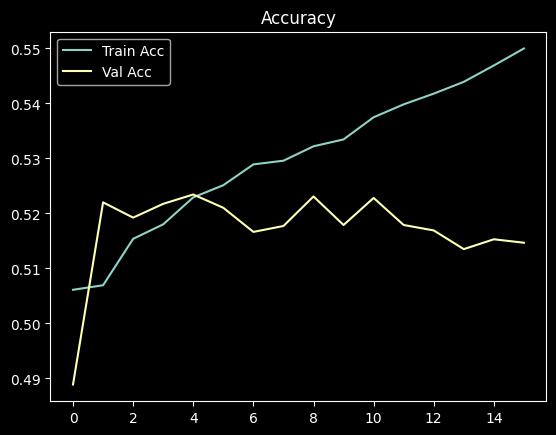

In [7]:

# ======================
# 7. Evaluation
# ======================
model = load_model(MODEL_SAVE_PATH)
y_pred_proba = model.predict(X_test_seq)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
acc = accuracy_score(y_test_seq, y_pred)
auc = roc_auc_score(y_test_seq, y_pred_proba)
prec = precision_score(y_test_seq, y_pred)
rec = recall_score(y_test_seq, y_pred)
f1 = f1_score(y_test_seq, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC: {auc:.4f}")
print(classification_report(y_test_seq, y_pred))

# History Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


--- Strategy Performance Comparison ---
         Metric   Strategy  Benchmark
   Total Return     49.8%     18.3%
Ann. Volatility      7.8%      7.8%
   Sharpe Ratio      2.29      0.97
   Max Drawdown     -5.3%     -4.5%


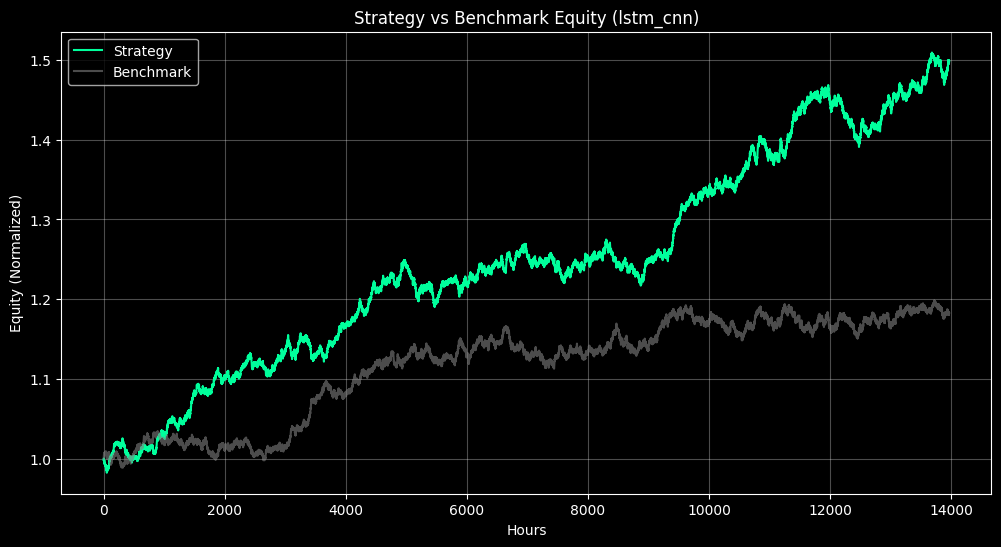

✅ Metadata saved to ../models/lstm_cnn/btc_lstm_cnn_hourly_metadata.json
   - Features: 20
   - Seq Len: 24


In [8]:

# ======================
# 8. Backtesting Framework
# ======================
def calculate_metrics(returns):
    # Metrics Calculation Helper
    cumulative = np.cumprod(1 + returns) - 1
    total_ret = cumulative[-1]
    ann_vol = np.std(returns) * np.sqrt(252 * 24)
    sharpe = (np.mean(returns) / np.std(returns)) * np.sqrt(252 * 24) if np.std(returns) > 0 else 0

    # Drawdown
    equity = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(equity)
    drawdown = (equity - running_max) / running_max
    max_dd = np.min(drawdown)
    return total_ret, ann_vol, sharpe, max_dd, equity

def backtest_strategy(y_actual, y_pred_proba):
    # Signals: >0.5 Buy, <=0.5 Sell/Short
    signals = np.where(y_pred_proba.flatten() > 0.5, 1, -1)

    # Synthetic Market Returns: +0.1% for Up, -0.1% for Down
    market_returns = y_actual * 0.001 + (1 - y_actual) * (-0.001)
    strategy_returns = signals * market_returns

    # Calculate Metrics
    strat_ret, strat_vol, strat_sharpe, strat_dd, strat_equity = calculate_metrics(strategy_returns)
    bench_ret, bench_vol, bench_sharpe, bench_dd, bench_equity = calculate_metrics(market_returns)

    # Print Table
    print(f"--- Strategy Performance Comparison ---")
    print(f"{'Metric':>15} {'Strategy':>10} {'Benchmark':>10}")
    print(f"{'Total Return':>15} {strat_ret:>9.1%} {bench_ret:>9.1%}")
    print(f"{'Ann. Volatility':>15} {strat_vol:>9.1%} {bench_vol:>9.1%}")
    print(f"{'Sharpe Ratio':>15} {strat_sharpe:>9.2f} {bench_sharpe:>9.2f}")
    print(f"{'Max Drawdown':>15} {strat_dd:>9.1%} {bench_dd:>9.1%}")

    return {
        'total_return': strat_ret,
        'annual_volatility': strat_vol,
        'sharpe_ratio': strat_sharpe,
        'max_drawdown': strat_dd,
        'equity_curve': strat_equity,
        'benchmark_equity': bench_equity
    }

results = backtest_strategy(y_test_seq, y_pred_proba)

# Equity Plot
plt.figure(figsize=(12, 6))
plt.plot(results['equity_curve'], label='Strategy', color=COLORS[1])
plt.plot(results['benchmark_equity'], label='Benchmark', color='gray', alpha=0.6)
plt.title(f'Strategy vs Benchmark Equity ({MODEL_NAME})')
plt.xlabel('Hours')
plt.ylabel('Equity (Normalized)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 💾 SAVE METADATA FOR DASHBOARD
# ==========================================
import json
import datetime

# Create metadata dictionary
metadata = {
    "model_name": MODEL_NAME,
    "model_type": "Deep Learning",
    "frequency": "1h",
    "target_asset": "BTC/USDT",
    "Architecture": {
        "layers": [layer.name for layer in model.layers],
        "trainable_parameters": int(sum([tf.size(w).numpy() for w in model.trainable_weights]))
    },
    "training_config": {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss_function": "binary_crossentropy",
        "batch_size": 64,
        "max_epochs": 50,
        "early_stopping_patience": 10
    },
    "performance_metrics": {
        "test_accuracy": float(acc),
        "test_auc_roc": float(auc),
        "test_precision": float(prec),
        "test_recall": float(rec),
        "test_f1_score": float(f1)
    },
    "backtesting": {
        "total_return": float(results['total_return']),
        "annual_volatility": float(results['annual_volatility']),
        "sharpe_ratio": float(results['sharpe_ratio']),
        "maximum_drawdown": float(results['max_drawdown'])
    },
    "data_info": {
        "total_samples": len(df),
        "training_samples": len(X_train_seq),
        "test_samples": len(X_test_seq),
        "sequence_length": int(WINDOW_SIZE),
        "feature_selection": "SelectKBest (k=20)"
    },
    "export_timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# Save metadata
with open(METADATA_SAVE_PATH, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Metadata saved to {METADATA_SAVE_PATH}")
print(f"   - Features: {len(top_features)}")
print(f"   - Seq Len: {WINDOW_SIZE}")
